# All functions needed for curve fitting
* get runtimes data: ```gcloud compute operations --format=json list > m21.json```
* get instance types: ```gcloud compute instances list > instances-m21.txt```

In [14]:
#Filtering data based on machine type
import json
import pandas as pd
import numpy as np
import time
import datetime
import dateutil.parser 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import math
from scipy.integrate import quad
from scipy.optimize import curve_fit
import glob
import inspect

#Instance types as a dic
def get_instance_types(path):
    try:
        frames = [ pd.read_csv(file,delim_whitespace=True, header=None) for file in sorted(glob.iglob(path)) ]
        instance_info = pd.concat(frames)
        instances = pd.Series(instance_info[2].values,index=instance_info[0].values).to_dict()
        del instances['NAME']
    except Exception as msg:
        print(msg)
        raise
    return instances
    
# convert to mins
def ttl_in_minutes(start_time, end_time):
    s=dateutil.parser.parse(start_time)
    e=dateutil.parser.parse(end_time)
    diff = e-s
    return diff.total_seconds()

#get all runtime information
def get_runtimes(path):
    out = dict()
    try:
        for file in sorted(glob.iglob(path)):
            with open(file) as json_file:  
                data = json.load(json_file)

            for entry in data:
                eid = entry['id']
                iname = entry['targetLink']
                if not iname in out:
                    if entry['operationType']=='insert':
                        out[iname] = (entry, np.nan)

            #Adding time data
            for entry in data:
                eid = entry['id']
                iname = entry['targetLink']      
                if entry['operationType']=='compute.instances.preempted':
                    if iname in out:
                        orig_entry = out[iname][0]
                        start_time = orig_entry['insertTime']
                        end_time = entry['insertTime']
                        ttl = ttl_in_minutes(start_time, end_time)
                        out[iname] = (orig_entry, ttl)

        #removing the datapoint which did not have endtime
        #removing the datapoint which have longer time than 30 hours
        for i in list(out):
            if np.isnan(out[i][1]):
                out.pop(i)
            elif (out[i][1]/3600.0 > 30):
                print(out[i][0]['targetLink'])
                out.pop(i)
    except Exception as msg:
        print(msg)
        raise
    return out

#Creating lists for eah machine type
def get_runtimes_for_machine_type(runtimes, instances):
    all_data = dict() 
    try:
        assert(isinstance(runtimes, dict))
        assert(isinstance(instances, dict))
        for key, value in runtimes.items():   
            iname = key.split('/')[-1]
            if iname in instances:
                if instances[iname] in all_data:
                    all_data[instances[iname]].append(value[1]/3600.0)
                else:
                    all_data[instances[iname]] = [value[1]/3600.0]

        #Sorting            
        for key, value in all_data.items():
            all_data[key] = np.sort(all_data[key])
            
    except Exception as msg:
        print(msg)
        raise
    return all_data

#curve fitting sinh
def func_approx(t, R, t0, tau, C):
    return R*np.sinh((t-t0)/tau) + C

#curve fitting inverse sinh
def func_approx_inverse_by_interpolation(value, R, t0, tau, C):
    t=np.linspace(value-2, value+2, 10000, endpoint=True)
    values =func_approx(t, R, t0, tau, C)
    index_close_to_one = np.argmin(np.abs(values-1.0))
    return t[index_close_to_one]

#curve fitting inverse: This is junk due to periodic? behaviour sinh
def func_approx_inverse(f, R, t0, tau, C):
    return tau*np.arcsinh((f/R)-C) + t0

#derivative of the function sinh
def func_approx_dif(t, R, t0, tau, C):
    return R*np.cosh((t-t0)/tau)/tau

#Expected value function sinh
def func_approx_exp(t, R, t0, tau, C):
    return t*R*np.cosh((t-t0)/tau)/tau

#curve fitting exp
def func_approx_exponential(t, alpha):
    return (1.0 - np.exp(-alpha*t))

#curve fitting inverse sinh
def func_approx_exponential_inverse_by_interpolation(value, alpha):
    t=np.linspace(value-2, value+2, 10000, endpoint=True)
    values =func_approx_exponential(t, alpha)
    index_close_to_one = np.argmin(np.abs(values-1.0))
    return t[index_close_to_one]

#derivative of the function exp
def func_approx_exponential_dif(t, alpha):
    return alpha*np.exp(-alpha*t)

#Expected value function exp
def func_approx_exponential_exp(t, alpha):
    return t*alpha*np.exp(-alpha*t)


# Compute the cross_entropy between two arrays
def cross_entropy(prediction, empirical, epsilon=1e-12):
    prediction = np.clip(prediction, epsilon, 1. - epsilon)
    return -np.sum(empirical*np.log(prediction+1e-9))/prediction.shape[0]

# Compute the MSE between two arrays
def mean_square_error(prediction, empirical):
    return (np.square(empirical - prediction)).mean(axis=0)

#generate curve fitting for all the data for one of the machine grouping
def fit_data(all_data_conc, func_approx, func_approx_exp):
    temp_data = dict() 
    try:
        #Check whether data size is at least 4 points and if it has points in span of 10 hrs
        if (len(all_data_conc) > 3) and ((max(all_data_conc) - min(all_data_conc)) > 10 ): 
            temp_data['t'] = np.sort(all_data_conc)
            temp_data['cdf'] = np.linspace(0,1,len(all_data_conc), endpoint=True)
            #fit the curve: method= 'trf', 'dogbox' or 'lm'
            #‘trf’ : Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
            #‘dogbox’ : dogleg algorithm with rectangular trust regions, typical use case is small problems with bounds. Not recommended for problems with rank-deficient Jacobian.
            #‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK. Doesn’t handle bounds and sparse Jacobians. Usually the most efficient method for small unconstrained problems.
            optimized_param, param_covariance = curve_fit(func_approx, temp_data['t'], temp_data['cdf'], maxfev=10000, method='dogbox')
            temp_data['optimized_params'] = optimized_param
            temp_data['param_covariance'] = param_covariance
            # Cross Entropy between fit and empirical data
            temp_data['cross_entropy'] = cross_entropy(func_approx(temp_data['t'], *temp_data['optimized_params']), temp_data['cdf'])
             # MSE between fit and empirical data
            temp_data['mean_square_error'] = mean_square_error(func_approx(temp_data['t'], *temp_data['optimized_params']), temp_data['cdf'])
            #Expected value computation
            I = quad(func=func_approx_exp, a=temp_data['t'][0], b=temp_data['t'][-1],args=tuple(optimized_param))
            temp_data['expected_value'] = I
    except Exception as msg:
        print(msg)
        raise
    return temp_data


#generate curve fitting data for all the curves considering machine grouping
def fit_all_types(all_data, func_approx, func_approx_exp):
    optimized_params = dict() 
    try:
        for key, value in all_data.items():
            #Check whether data size is at least 4 points and if it has points in span of 10 hrs
            if (len(value) > 3) and ((max(value) - min(value)) > 10 ):
                optimized_params[key] = fit_data(value, func_approx, func_approx_exp)
    except Exception as msg:
        print(msg)
        raise
    return optimized_params

# Plot the curve fitting data
def plot_CDF(key, value, func_approx, func_approx_dif, func_approx_inverse_by_interpolation):
    plt.figure(figsize=(5, 4))
    #plot data points
    plt.scatter(value['t'], value['cdf'], c='green', label='Empirical', s=5)
    
    #find the value of t for when func_approx = 1.0
    edge_point_near_one = func_approx_inverse_by_interpolation(value['t'][-1],*value['optimized_params'] )
    
    # Intepolate to get more data points for t
    #t=np.linspace(value['t'][0], value['t'][-1], 10000, endpoint=True)
    t=np.linspace(0, edge_point_near_one, 10000, endpoint=True)
    #Plot the fitted function : label='F(t)=R*np.sinh((t-t0)/tau) + C'
    plt.plot(t, func_approx(t, *value['optimized_params']), c= "red",  label='F(t)')
    #differentiation of the funtion : label='dF(t)=R*np.cosh((t-t0)/tau)/tau'
    plt.plot(t, func_approx_dif(t, *value['optimized_params']), c= "blue", label='dF(t)')
    x = plt.legend()
    plt.xlabel("Time(hrs)")
    plt.ylabel("CDF")
    #Plot text value['t']
    #creating function args list
    txt = ', fit: '
    function_args = inspect.getfullargspec(func_approx)[0]
    for i in range(len(function_args) -1):
        if float("{:.3f}".format( value['optimized_params'][i])) == 0.0:
            txt = txt +  function_args[i+1] +'=%.3E, '
        else:
            txt = txt +  function_args[i+1] +'=%.3f, ' 
        
    txt = txt % tuple(value['optimized_params'])
    text = key + txt + ', E(t)=%.3f ' % (value['expected_value'][0]) + ', CrossEntropy=%.3f ' % (value['cross_entropy'])
    text = text + ', MSE=%.3f ' % (value['mean_square_error'])
    plt.title(text)

# Plot the curve fitting data
def plot_two_CDF(key, value,value2, func_approx, func_approx_dif, func_approx_inverse_by_interpolation,  
                 func_approx2, func_approx_dif2, func_approx_inverse_by_interpolation2):
    
    plt.figure(figsize=(5, 4))
    #plot data points
    plt.scatter(value['t'], value['cdf'], c='green', label='Empirical', s=5)
    
    #find the value of t for when func_approx = 1.0
    edge_point_near_one = func_approx_inverse_by_interpolation(value['t'][-1],*value['optimized_params'] )
    
    # Intepolate to get more data points for t
    #t=np.linspace(value['t'][0], value['t'][-1], 10000, endpoint=True)
    t=np.linspace(0, edge_point_near_one, 10000, endpoint=True)
    #Plot the fitted function : label='F(t)=R*np.sinh((t-t0)/tau) + C'
    plt.plot(t, func_approx(t, *value['optimized_params']), c= "red",  label='F(t)')
    #differentiation of the funtion : label='dF(t)=R*np.cosh((t-t0)/tau)/tau'
    plt.plot(t, func_approx_dif(t, *value['optimized_params']), c= "blue", label='dF(t)')
    
    #2nd plot
    edge_point_near_one2 = func_approx_inverse_by_interpolation2(value2['t'][-1],*value2['optimized_params'] )
    t2=np.linspace(0, edge_point_near_one2, 10000, endpoint=True)
    plt.plot(t2, func_approx2(t2, *value2['optimized_params']), c= "black",  label='F2(t)')
    #plt.plot(t2, func_approx_dif2(t2, *value2['optimized_params']), c= "purple", label='dF2(t)')
    
    x = plt.legend()
    plt.xlabel("Time(hrs)")
    plt.ylabel("CDF")
    #Plot text value['t']
    #creating function args list
    txt = ', fit: '
    function_args = inspect.getfullargspec(func_approx)[0]
    for i in range(len(function_args) -1):
        if float("{:.3f}".format( value['optimized_params'][i])) == 0.0:
            txt = txt +  function_args[i+1] +'=%.3E, '
        else:
            txt = txt +  function_args[i+1] +'=%.3f, ' 
        
    txt = txt % tuple(value['optimized_params'])
    text = key + txt + ', E(t)=%.3f ' % (value['expected_value'][0]) + ', CrossEntropy=%.3f ' % (value['cross_entropy'])
    text = text + ', MSE=%.3f ' % (value['mean_square_error'])
    plt.title(text)    
    
# Plot the curve fitting data
def plot_all_types(optimized_params, func_approx, func_approx_dif, func_approx_inverse_by_interpolation):
    try:
        for key, value in optimized_params.items():
            #Plot text
            plot_CDF(key, value, func_approx, func_approx_dif, func_approx_inverse_by_interpolation)
            
    except Exception as msg:
        print(msg)
        raise

# Get runtime data per machine type

In [15]:
#Get instance data
instances = get_instance_types('instance-data/instances*.txt')

#Get runtime data
runtime_data = get_runtimes('runtime-data/*.json')

#Get runtime data per machine type
all_data = get_runtimes_for_machine_type(runtime_data, instances)

print(all_data)

https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus2
https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus3
{'n1-standard-1': array([ 1.82317889, 21.32407972, 24.01686111, 24.02448528, 24.70971972]), 'n1-standard-16': array([ 0.11144944,  0.65652278, 10.24200389, 10.24634806, 10.80266306,
       12.99917944, 24.02222611, 24.20612111, 24.20999528, 24.21473861,
       24.22076194, 24.70821028]), 'n1-standard-2': array([ 0.34604472,  0.50689056,  0.664455  ,  1.29130583,  6.19542833,
       24.01101361, 24.02060806, 24.57288722]), 'n1-standard-32': array([24.01877889, 24.57137167, 24.70246194]), 'n1-standard-4': array([ 0.24884056,  1.33633722, 24.01728472]), 'n1-highcpu-16': array([ 0.0260625 ,  0.06134028,  0.09666833,  0.18160167,  0.21820611,
        0.22848222,  0.25093889,  0.34889722,  0.42989889,  0.50031778,
        0.76994278,  0.78795028,  0.95020194,  2.19073861,  2.73989667,
        2.8316275 , 

# Curve fitting with sinh for for all the results without considering machine type

210


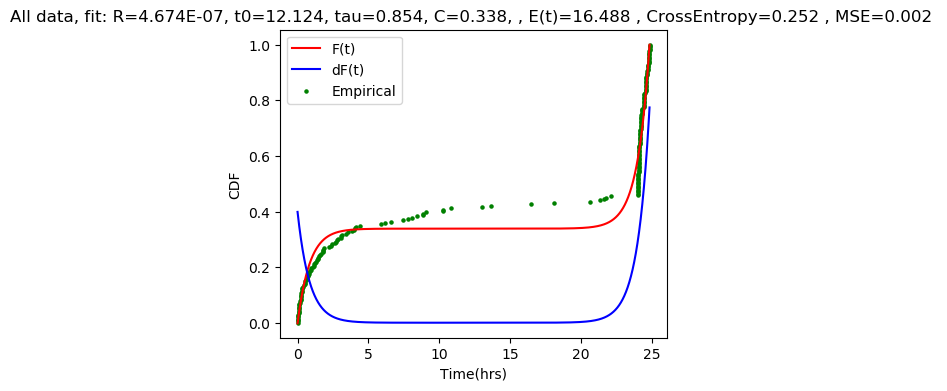

In [16]:
all_data_conc = []
for key, value in all_data.items():
    for i in range(value.shape[0]):
        all_data_conc.append(value[i]) 

print(len(all_data_conc))
        
#Fit the data for all the data points
opt_params_all = fit_data(all_data_conc, func_approx, func_approx_exp)

plot_CDF("All data",opt_params_all, func_approx, func_approx_dif, func_approx_inverse_by_interpolation)

# Curve fitting with sinh for different machine types usig scipy

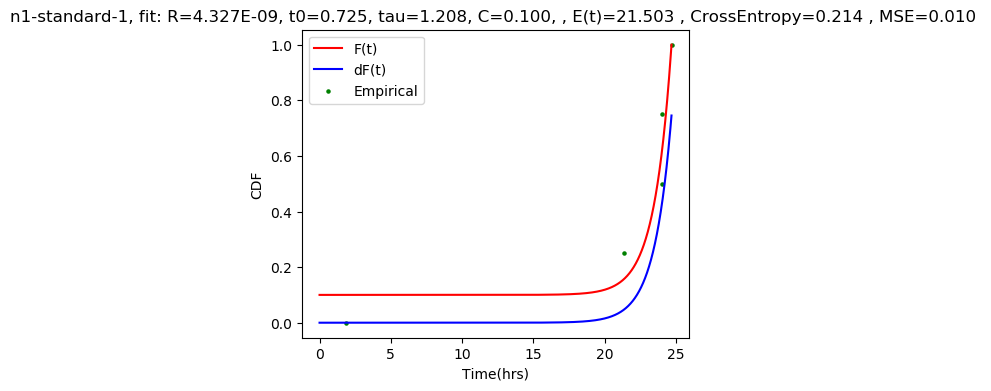

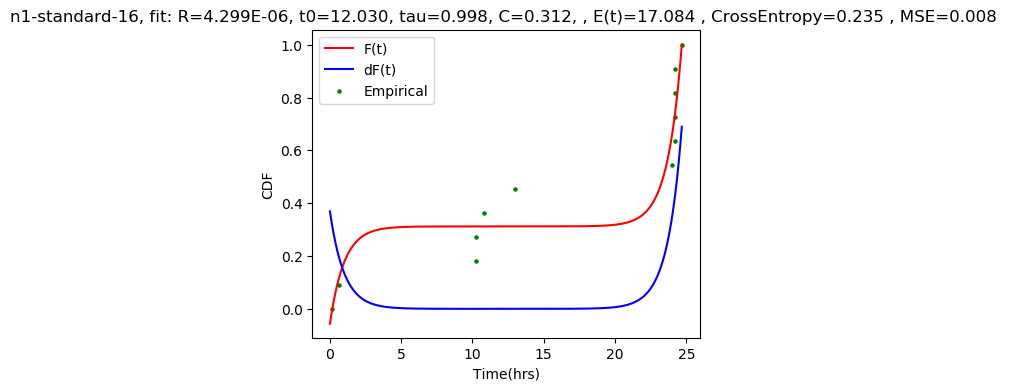

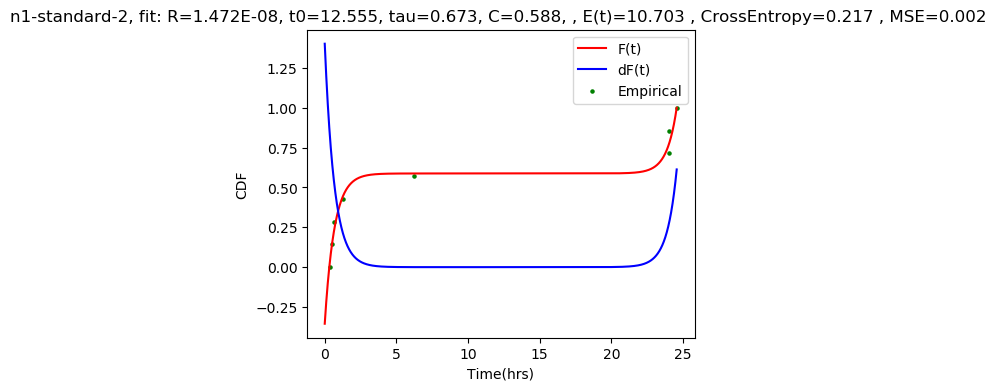

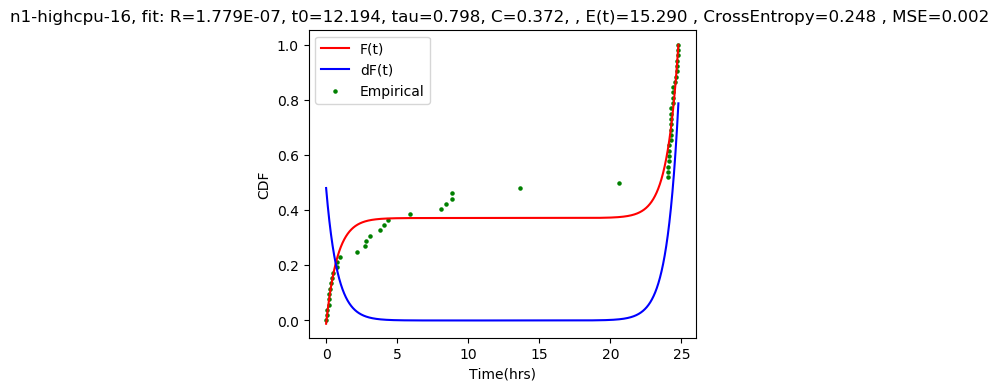

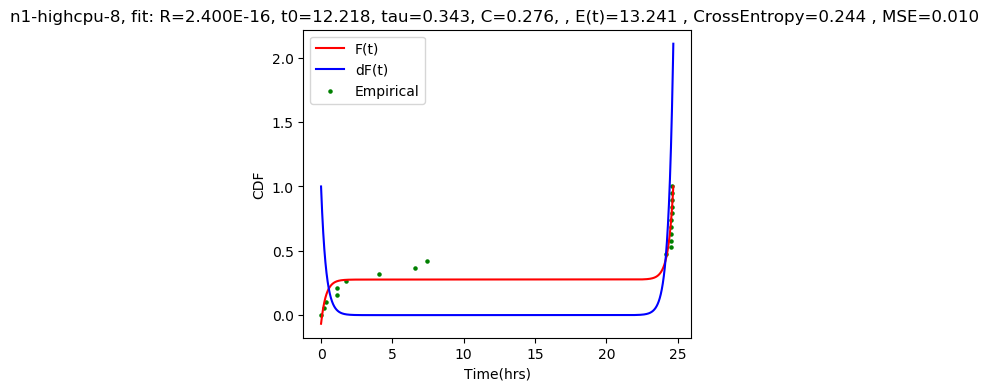

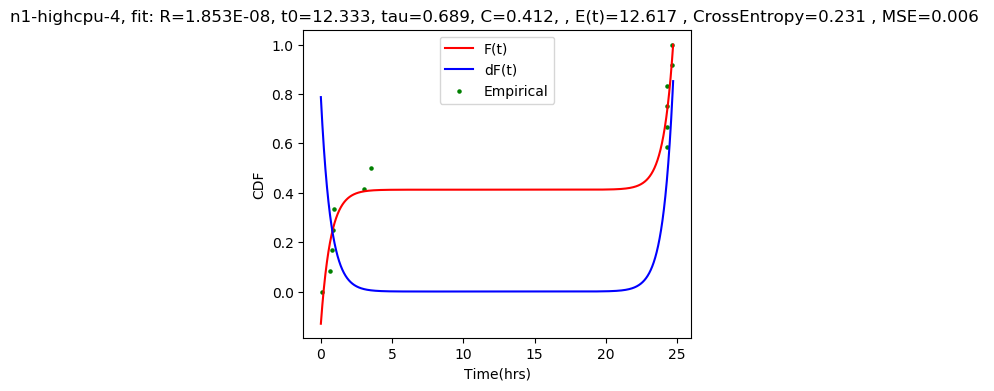

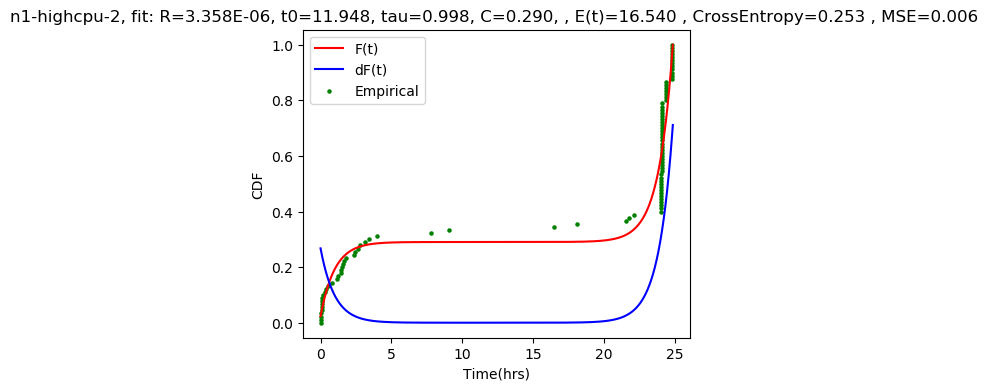

In [17]:
#generate curve fitting data for all the curves
optimized_parameters = fit_all_types(all_data, func_approx, func_approx_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters, func_approx, func_approx_dif, func_approx_inverse_by_interpolation)


# Curve fitting with exp for for all the results without considering machine type

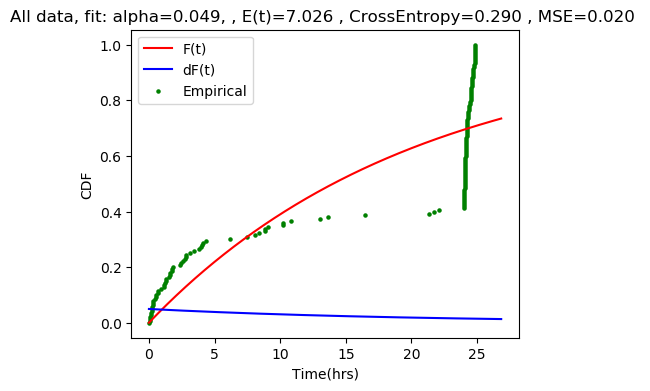

In [10]:
all_data_conc2 = []
for key, value in all_data.items():
    for i in range(value.shape[0]):
        all_data_conc2.append(value[i]) 

#Fit the data for all the data points
opt_params_all2 = fit_data(all_data_conc, func_approx_exponential, func_approx_exponential_exp)

plot_CDF("All data",opt_params_all2, func_approx_exponential, func_approx_exponential_dif, func_approx_exponential_inverse_by_interpolation)

# Curve fitting with exp for different machine types usig scipy

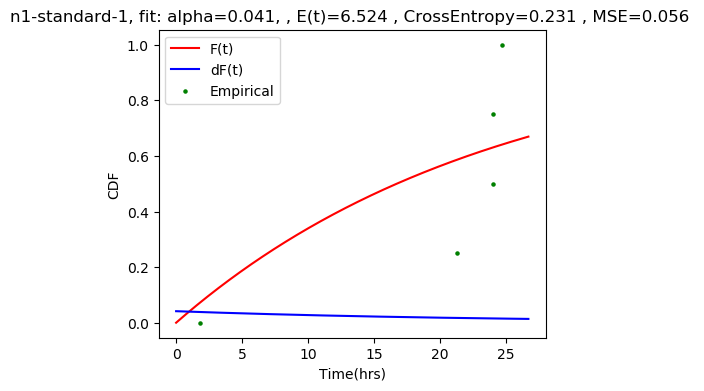

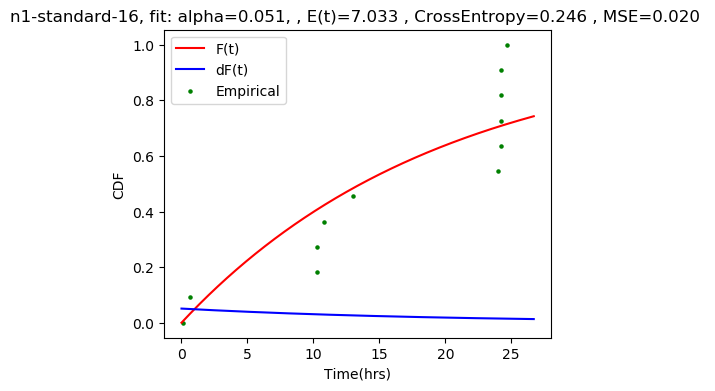

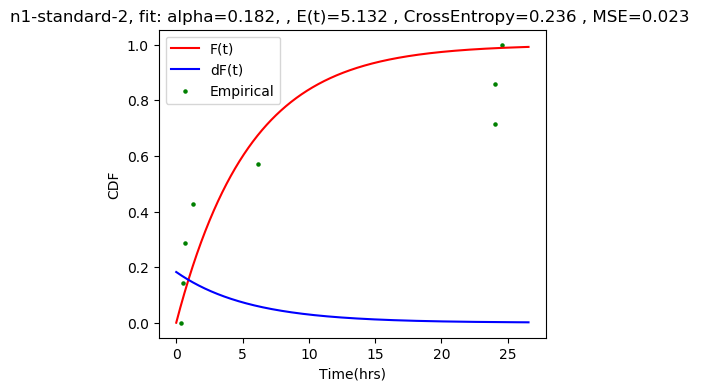

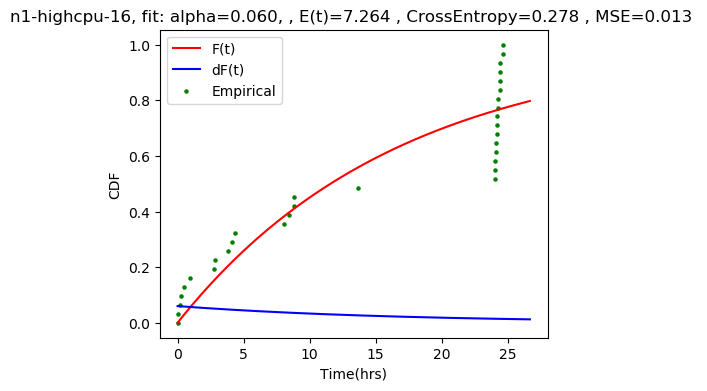

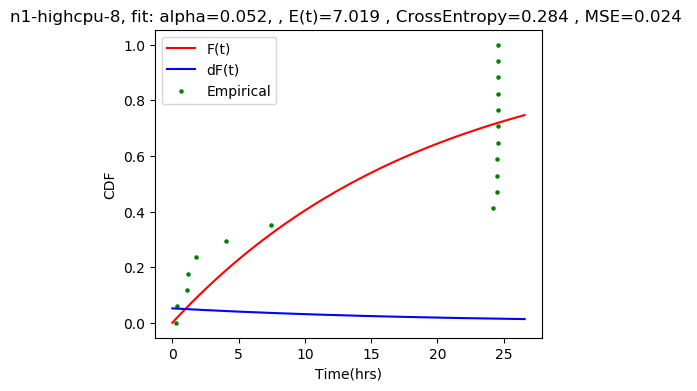

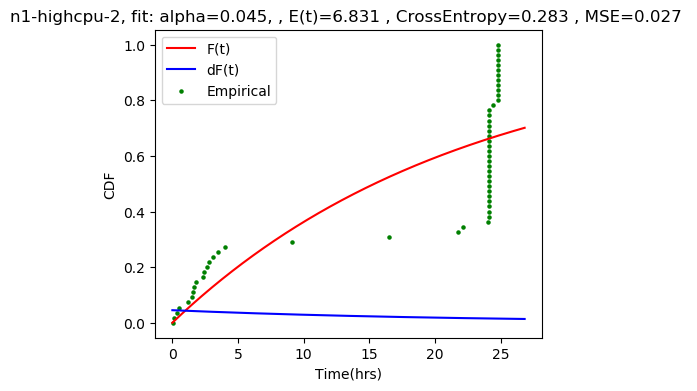

In [11]:
#generate curve fitting data for all the curves
optimized_parameters = fit_all_types(all_data, func_approx_exponential, func_approx_exponential_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters, func_approx_exponential, func_approx_exponential_dif, func_approx_exponential_inverse_by_interpolation)


# Plotting two functions in one plot

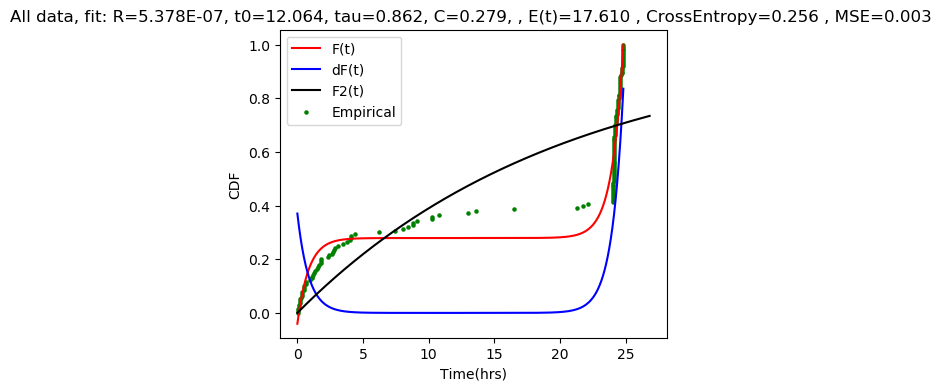

In [13]:
plot_two_CDF("All data",opt_params_all, opt_params_all2, func_approx, func_approx_dif, func_approx_inverse_by_interpolation,  
                 func_approx_exponential, func_approx_exponential_dif, func_approx_exponential_inverse_by_interpolation)

# Expected value comparison of scipy quad and analytical solution

In [12]:
#Analytical solution
#intergration to find the expected value
#dPT = lambda t, R, t0, tau, C: t*R*np.cosh((t-t0)/tau)/tau
# When you integrate dPT by t: IdPT
IdPT = lambda t, R, t0, tau, C: R/tau* ( t*tau*np.sinh((t-t0)/tau) - (tau**2)*np.cosh((t-t0)/tau) )
t=opt_params_all['t'][-1]
ip_upper_bound = IdPT(t,*opt_params_all['optimized_params'])
t=opt_params_all['t'][0]
ip_lower_bound = IdPT(t,*opt_params_all['optimized_params'])
#accroding to mean value theorm
expected_value = (ip_upper_bound - ip_lower_bound)
expected_value

17.610192894509222

In [62]:
#Numerical Integration
dPT = lambda t, R, t0, tau, C: t*R*np.cosh((t-t0)/tau)/tau
I = quad(func=dPT, a=opt_params_all['t'][0], b=opt_params_all['t'][-1],args=tuple(opt_params_all['optimized_params']))
#accroding to mean value theorm
expected_value = I[0]
expected_value

17.610192894509204